### Objective and Methodology


<font size="4" face="verdana" color="black">We aim to predict whether a bank's customer leaves or not by using a series of account information.The dataset is **tabular** and the type of task is **classification**, We (naturally) think boosting models probably are the best candidates. We will attempt ⓵**XGBoost** ⓶**LightGBM** ⓷**RandomForest** models, a ⓸**stacking** model and a ⓹**voting**model of them on the dataset. Also, we will apply the best performing deep learning model on tabular data : ⓺**TabNet** to see if it can cath the performance of the others.
We will use **Optuna** for hyperparameter optimizations. 

</font>


### About the Dataset

#### Content
* RowNumber—corresponds to the record (row) number and has no effect on the output.

* CustomerId—contains random values and has no effect on customer leaving the bank.
* Surname—the surname of a customer has no impact on their decision to leave the bank.
* CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
* Geography—a customer’s location can affect their decision to leave the bank.
* Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
* Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
* Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and    less likely to leave a bank.
* Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
* NumOfProducts—refers to the number of products that a customer has purchased through the bank.
* HasCrCard—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit card are less likely to leave the bank.
* IsActiveMember—active customers are less likely to leave the bank.
* EstimatedSalary—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher   salaries.

* Exited—whether or not the customer left the bank.

In [1]:
!pip install pytorch_tabnet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.offline import init_notebook_mode
import os 
os.chdir("/kaggle/input")
import gc

import torch
from pytorch_tabnet.tab_model import TabNetClassifier



from sklearn.preprocessing import PowerTransformer,OneHotEncoder, LabelEncoder,OrdinalEncoder,StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score,KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier,VotingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

# optuna
import optuna
from optuna import Trial, visualization
from optuna.visualization import plot_optimization_history, plot_param_importances

#Set the magic number!
SEED=40

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00


 ##### Load the data set

In [2]:
df = pd.read_csv("bank-churn/churn.csv", index_col=0)

In [3]:
# data summary 
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


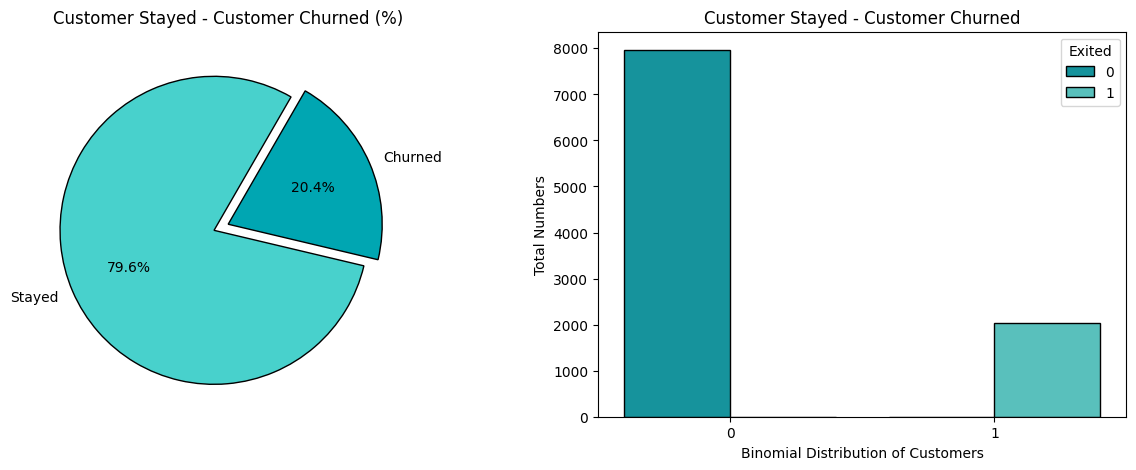

In [4]:
exited_customers_counts = list(df['Exited'].value_counts())
tot = sum(exited_customers_counts)
percent = [exited_customers_counts[0] / tot  * 100, exited_customers_counts[1] / tot  * 100]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.pie(percent, 
        labels = ['Stayed', 'Churned'], 
        autopct = '%1.1f%%', 
        startangle = 60,
        explode = (0.1,0),
        colors = ['#48D1CC', '#00a6b2'], 
        wedgeprops = {'edgecolor' : 'black','antialiased' : True})
plt.title('Customer Stayed - Customer Churned (%)')


plt.subplot(1, 2, 2)
ax = sns.countplot(x = df['Exited'],
                   hue = df['Exited'], 
                   palette = ['#00a6b2', '#48D1CC'], 
                   edgecolor = "black" )
ax.set_xlabel('Binomial Distribution of Customers')
ax.set_ylabel('Total Numbers')

plt.title('Customer Stayed - Customer Churned');

In [5]:
#Remove redundant variables 
df = df.drop(["CustomerId","Surname"], axis = 1)

In [6]:
#encoding categorical variables
df = pd.get_dummies(df, columns =["Geography","Gender"], drop_first = True)

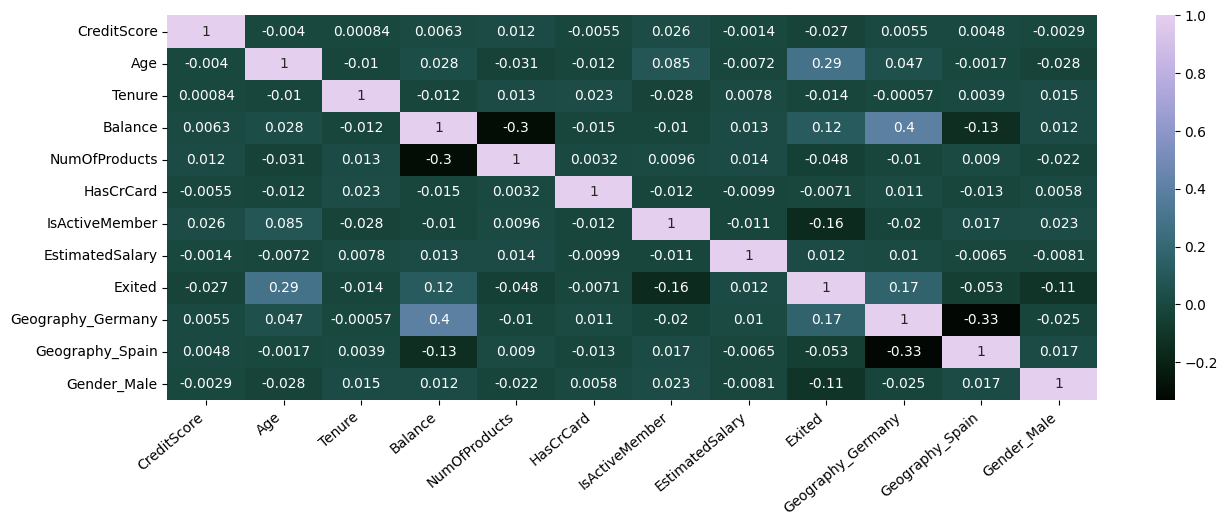

In [9]:
plt.figure(figsize=(15, 5))
sns.heatmap(df.corr(),
            cmap = sns.cubehelix_palette(start=2, rot=0.5, dark=0.02, light=.85, reverse=True, as_cmap=True),
            annot=True)
plt.xticks(rotation=40, ha='right');

In [10]:
X = df.drop('Exited',axis=1)
y = df['Exited']


##### Apply __SMOTE__ to handle imbalanced data, generating synthetic samples for the minority class to balance the dataset

In [11]:
X_resampled,y_resampled = SMOTE(sampling_strategy = 'minority').fit_resample(X,y)

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled,y_resampled,test_size = 0.2,random_state=SEED)

In [13]:
# get categorical columns
categorical = [col for col in df.columns if (df.dtypes[col] =='object' or len(df[col].unique())<=11) and 
                                            col not in 'Exited']

# Numeric columns
dummy_cols = ["Gender_Male","Geography_Germany","Geography_Spain"]
numeric = [col for col in df.columns if df[col].dtype != "object"
                        and df[col].nunique() >11
                        and col not in dummy_cols
                        and col not in 'Exited']

In [14]:
#scalling numberical variables
robust_scaler = RobustScaler()
X_train[numeric] = robust_scaler.fit_transform(X_train[numeric])
X_test[numeric] = robust_scaler.transform(X_test[numeric])

In [15]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

#### train model with StratifiedKFold

In [16]:
def train_model(model,model_name,X,y,X_test,fold):
    auc_scores = []
    test_predictions = []
    stratified_kf = StratifiedKFold(n_splits = fold,random_state = SEED, shuffle = True)
    print(f'We are using {model_name}')
    for fold,(train_index,validation_index) in enumerate(stratified_kf.split(X,y)):
        X_train,X_validation = X.iloc[train_index],X.iloc[validation_index]
        y_train, y_validation = y[train_index],y[validation_index]
        
        eval_set = [(X_validation,y_validation)]
        print(f"Fold {fold + 1}")
        
        if model_name == 'lgb' or model_name =='lgbm':
            model.fit(X_train, y_train, eval_set= eval_set)
        elif model_name == 'xgb':
            model.fit(X_train, y_train, eval_set= eval_set, verbose = False,)
  
        else:
            model.fit(X_train, y_train, eval_set= eval_set, verbose = False)
            
        y_validation_pred = model.predict_proba(X_validation)[:,1]
        auc = roc_auc_score(y_validation,y_validation_pred) 
        print("AUC score is: ",auc)
        
        auc_scores.append(auc)
        
        if len(test_predictions) ==0:
            test_predictions = model.predict_proba(X_test)[:,1]
        else:
            test_predictions += model.predict_proba(X_test)[:,1]
            
        del X_train,y_train,X_validation,y_validation
        gc.collect()
        
        if fold>=1:
            test_pred_avg = test_predictions/fold
        else:
            test_pred_avg = test_predictions
        
    print(f"{model_name} model has training - AUC score ---- {np.mean(auc)}")

    print(f"{model_name} model has testing - AUC score ---- {roc_auc_score(y_test,test_pred_avg)}")
    
    feature_importance = pd.DataFrame({'feature_names':X.columns,'feature_importance':model.feature_importances_})
    feature_importance.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    plt.figure(figsize=(10,8),dpi=100)
    #Plot Searborn bar chart
    sns.barplot(x=feature_importance['feature_importance'], y=feature_importance['feature_names'])
    #Add chart labels
    plt.title(model_name + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [21]:
def xgb_objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=int(SEED), shuffle=True)
    params  = {
          'n_estimators':trial.suggest_int("n_estimators", 50, 1000),
          'learning_rate': trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
          'max_depth': trial.suggest_int('max_depth',3,15),
          'colsample_bytree': trial.suggest_float("colsample_bytree", 0.05, 1.0),
          'min_child_weight': trial.suggest_int("min_child_weight", 1, 20),
          'subsample': trial.suggest_float('subsample',0.1,0.99,log=True),
          'gamma': trial.suggest_categorical('gamma',[0, 0.25, 0.5, 1.0]),
          'reg_lambda': trial.suggest_categorical('reg_lambda',[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]),
          
         }

    # learning
    model = XGBClassifier(**params)        
    model.fit(X_train, y_train, 
              verbose=False) 
    y_predict = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_predict) 
    
    return auc

#### Finding Optimal Hyperparameters for XGBoost

[I 2024-08-12 12:41:48,644] A new study created in memory with name: no-name-4404a4d7-94f6-46b0-8fac-bc37fdcb67c5
[I 2024-08-12 12:41:49,949] Trial 1 finished with value: 0.9020494425006655 and parameters: {'n_estimators': 164, 'learning_rate': 0.038956105687566786, 'max_depth': 10, 'colsample_bytree': 0.46023893411856037, 'min_child_weight': 18, 'subsample': 0.2031628638403035, 'gamma': 0.25, 'reg_lambda': 100.0}. Best is trial 1 with value: 0.9020494425006655.
[I 2024-08-12 12:41:50,939] Trial 0 finished with value: 0.8952192712953136 and parameters: {'n_estimators': 256, 'learning_rate': 0.00304253389701981, 'max_depth': 7, 'colsample_bytree': 0.6738187598378844, 'min_child_weight': 4, 'subsample': 0.2569404390191877, 'gamma': 0, 'reg_lambda': 100.0}. Best is trial 1 with value: 0.9020494425006655.
[I 2024-08-12 12:41:53,083] Trial 4 finished with value: 0.8834589814991224 and parameters: {'n_estimators': 516, 'learning_rate': 0.002609356928189141, 'max_depth': 6, 'colsample_bytree'

**BEST TRIAL**
Best Score:  0.9500192415182757
**XGBoost Tuned Hyperparameters**
Best trial: score 0.9500192415182757,
params {'n_estimators': 991, 'learning_rate': 0.0832337587768422, 'max_depth': 11, 'colsample_bytree': 0.4719877589795393, 'min_child_weight': 1, 'subsample': 0.9172561062087231, 'gamma': 0, 'reg_lambda': 1.0}
We are using xgb
Fold 1
AUC score is:  0.9444512217662933
Fold 2
AUC score is:  0.9363313740711987
Fold 3
AUC score is:  0.9329420970266042
Fold 4
AUC score is:  0.9427007634312077
Fold 5
AUC score is:  0.9381689110800725
xgb model has training - AUC score ---- 0.9381689110800725
xgb model has testing - AUC score ---- 0.9515903559851417


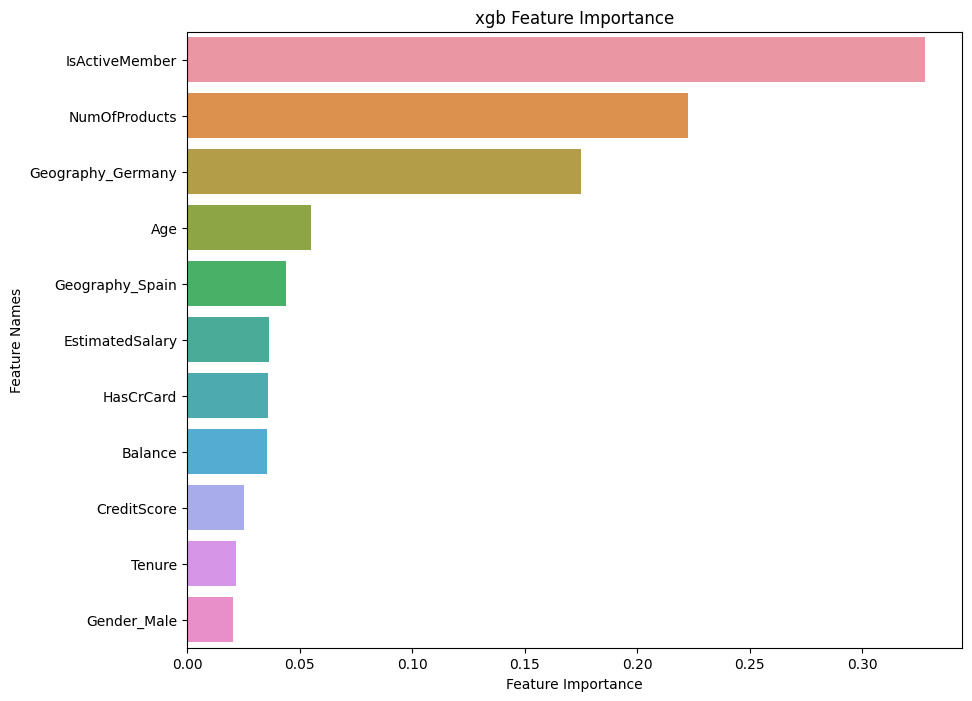

In [22]:
n_trials = int(100)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study.optimize(xgb_objective, n_trials = n_trials, n_jobs = -1)

print('**BEST TRIAL**')
print("Best Score: ", study.best_value)
print('**XGBoost Tuned Hyperparameters**')
print('Best trial: score {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))


xgb_params = study.best_params
xgb_model = XGBClassifier(**xgb_params)
train_model(xgb_model, 'xgb', X_train, y_train, X_test, 5)

#### Finding Optimal Hyperparameters for RandomForest

In [19]:
def rf_objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=int(SEED), shuffle=True)
   
    params = {'n_estimators':trial.suggest_int("n_estimators", 10, 1000,step=1, log=True),
              'max_depth': trial.suggest_int("max_depth", 2, 40,step=1),
              'min_samples_split': trial.suggest_int("min_samples_split", 2, 32),
              'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 32),
              'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
              'criterion':trial.suggest_categorical('criterion',['gini','entropy','log_loss'])
             }

    model = RandomForestClassifier(random_state=SEED, **params)
   
    model.fit(X_train,y_train)
    
    

    y_predict = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_predict) 
    return auc

n_trials = int(100)

# set logging level
# optuna.logging.set_verbosity(optuna_verbosity)

study_rf = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study_rf.optimize(rf_objective, n_trials = n_trials, n_jobs = -1)

print('**BEST TRIAL**')
print("Best Score: ", study_rf.best_value)
print('**RandomForest Tuned Hyperparameters**')
print('Best trial: score {},\nparams {}'.format(study_rf.best_trial.value,study_rf.best_trial.params))
    

[I 2024-08-12 12:34:19,601] A new study created in memory with name: no-name-d2492749-881d-4f23-9d58-45949fd3ed98
[I 2024-08-12 12:34:20,425] Trial 2 finished with value: 0.9148215207234307 and parameters: {'n_estimators': 20, 'max_depth': 34, 'min_samples_split': 17, 'min_samples_leaf': 29, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 2 with value: 0.9148215207234307.
[I 2024-08-12 12:34:20,706] Trial 0 finished with value: 0.9189019843367733 and parameters: {'n_estimators': 28, 'max_depth': 22, 'min_samples_split': 23, 'min_samples_leaf': 17, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9189019843367733.
[I 2024-08-12 12:34:21,614] Trial 4 finished with value: 0.9258401603922495 and parameters: {'n_estimators': 35, 'max_depth': 39, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'log_loss'}. Best is trial 4 with value: 0.9258401603922495.
[I 2024-08-12 12:34:21,793] Trial 3 finished with value: 0.92023

**BEST TRIAL**
Best Score:  0.940079388611797
**RandomForest Tuned Hyperparameters**
Best trial: score 0.940079388611797,
params {'n_estimators': 238, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'log_loss'}


In [20]:
best_rf_params = study_rf.best_params
rf_model = RandomForestClassifier(**best_rf_params)

#### Finding Optimal Hyperparameters for LightGBM

In [23]:

def lgb_objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=int(SEED), shuffle=True)

    params = {
        'objective': 'binary', 
         'metric':'auc',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate' : trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Learning
    model = lgb.LGBMClassifier(**params,verbose=-1)        
    model.fit(X_train, y_train) 
    val_pred = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, val_pred) 
    
    return auc


In [24]:
n_trials = int(100)

study_2 = optuna.create_study(direction = "maximize", sampler = optuna.samplers.TPESampler(seed=int(SEED)))
study_2.optimize(lgb_objective, n_trials = n_trials, n_jobs = -1)

print('BEST TRIAL')
print("Best Score: ", study_2.best_value)
print('LGBM Tuned Hyperparameters are:')
print(study_2.best_trial.params)

[I 2024-08-12 12:49:22,187] A new study created in memory with name: no-name-94f2a435-44e5-4507-8510-81138512125c
[I 2024-08-12 12:49:25,678] Trial 0 finished with value: 0.9045604290921663 and parameters: {'n_estimators': 612, 'learning_rate': 0.0010525738402695193, 'lambda_l1': 0.00010312915228566155, 'lambda_l2': 0.003486517604619023, 'num_leaves': 11, 'feature_fraction': 0.737030279462837, 'bagging_fraction': 0.692148387150525, 'bagging_freq': 6, 'min_child_samples': 24}. Best is trial 0 with value: 0.9045604290921663.
[I 2024-08-12 12:49:26,830] Trial 3 finished with value: 0.924898019953139 and parameters: {'n_estimators': 195, 'learning_rate': 0.005629258321199893, 'lambda_l1': 0.12970225364544308, 'lambda_l2': 0.0032586768277298394, 'num_leaves': 134, 'feature_fraction': 0.5541891016098399, 'bagging_fraction': 0.8795415350543235, 'bagging_freq': 4, 'min_child_samples': 75}. Best is trial 3 with value: 0.924898019953139.
[I 2024-08-12 12:49:33,293] Trial 1 finished with value: 0

BEST TRIAL
Best Score:  0.9567594507398206
LGBM Tuned Hyperparameters are:
{'n_estimators': 887, 'learning_rate': 0.0275262437664751, 'lambda_l1': 1.1331584278625303e-05, 'lambda_l2': 3.527609592462286e-08, 'num_leaves': 212, 'feature_fraction': 0.8099670527388118, 'bagging_fraction': 0.7647219812685966, 'bagging_freq': 4, 'min_child_samples': 5}


We are using lgb
Fold 1
AUC score is:  0.9527688440353407
Fold 2
AUC score is:  0.9444567668478059
Fold 3
AUC score is:  0.9404125540645449
Fold 4
AUC score is:  0.9505183704677626
Fold 5
AUC score is:  0.9470878281672906
lgb model has training - AUC score ---- 0.9470878281672906
lgb model has testing - AUC score ---- 0.9573744002049402


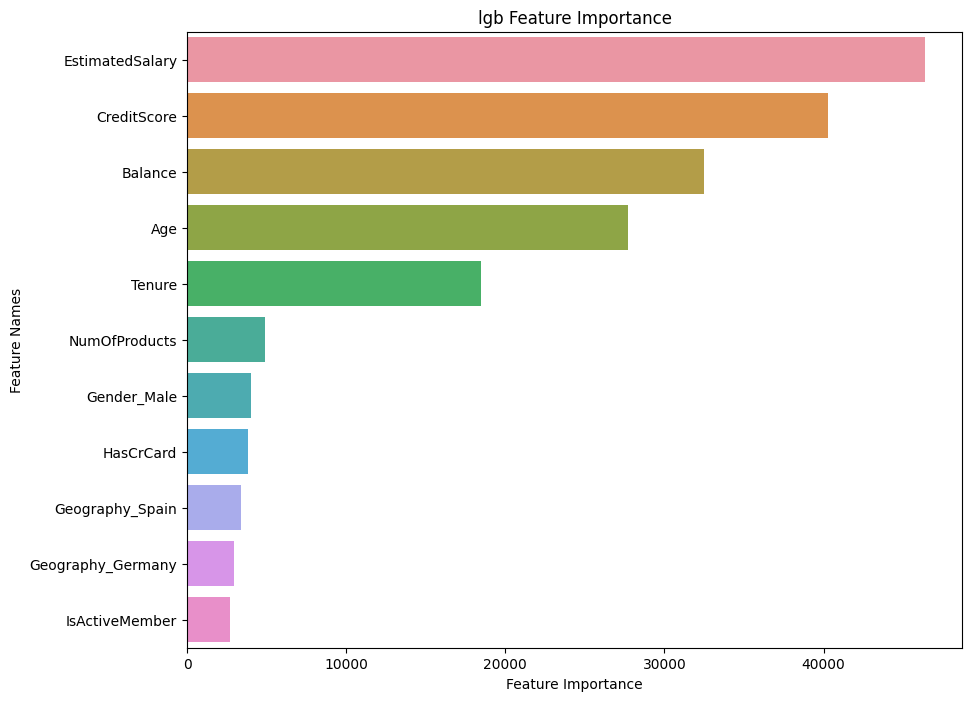

In [25]:
lgb_params = study_2.best_trial.params

lgb_model = lgb.LGBMClassifier(**lgb_params,verbose=-1)

train_model(lgb_model, 'lgb', X_train, y_train, X_test, 5)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled.values.astype(np.float32), y_resampled.values.astype(np.float32), test_size=0.2, random_state=int(SEED))

#### Parameters for TabNet

* input_dim : int
  
  Number of features
  
* output_dim : int or list of int for multi task classification
  
  Dimension of network output
  
  examples : one for regression, 2 for binary classification etc...
* n_d : int
  
  Dimension of the prediction  layer (usually between 4 and 64)
* n_a : int
  
  Dimension of the attention  layer (usually between 4 and 64)
* n_steps : int
  
  Number of successive steps in the network (usually between 3 and 10)
* gamma : float
  
  Float above 1, scaling factor for attention updates (usually between 1.0 to 2.0)
* n_independent : int
  
  Number of independent GLU layer in each GLU block (default 2)
* n_shared : int
  
  Number of independent GLU layer in each GLU block (default 2)
* epsilon : float
  
  Avoid log(0), this should be kept very low
* virtual_batch_size : int
  
  Batch size for Ghost Batch Normalization
* momentum : float
  
  Float value between 0 and 1 which will be used for momentum in all batch norm
* mask_type : str
  
  Either "sparsemax" or "entmax" : this is the masking function to use
* group_attention_matrix : torch matrix
  
  Matrix of size (n_groups, input_dim), m_ij = importance within group i of feature j

#### Finding Optimal Hyperparameters for TabNet

In [ ]:
# this takes a lot time
def objective(trial):
    
   # X_train, X_test, y_train, y_test = train_test_split(X_resampled.values.astype(np.float32), y_resampled.values.astype(np.float32), test_size=0.22, random_state=int(SEED), shuffle=True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    hyperparams = {'n_a': trial.suggest_categorical('n_a', [4, 8,16, 24, 32, 40,45,50,60,64]),
        'n_d': trial.suggest_categorical('n_d', [4, 8,16, 24, 32, 40,45,50,60,64]),
        'n_steps': trial.suggest_int('n_steps', 3, 10,1),
        'n_shared': trial.suggest_int("n_shared", 1, 5),
        'gamma': trial.suggest_categorical('gamma', [1.0, 1.1,1.2, 1.5, 1.8,2.0]),
        'lambda_sparse': trial.suggest_categorical('lambda_sparse', [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0]),
        'virtual_batch_size': trial.suggest_categorical('virtual_batch_size', [128, 256, 512, 1024]),
        'lr': trial.suggest_categorical('lr', [0.005, 0.01, 0.02, 0.025]),
        'gamma_decay': trial.suggest_categorical('gamma_decay', [0.4, 0.8, 0.9, 0.95]),
        'mask_type': trial.suggest_categorical('mask_type', ['entmax', 'sparsemax']),
        'momentum': trial.suggest_float("momentum", 0.05, 1.0)
        #'scheduler_fn':trial.suggest_categorical('scheduler_fn',[torch.optim.lr_scheduler.StepLR,torch.optim.lr_scheduler.ReduceLROnPlateau]),
       
    }
    
    #n_d: int, n_a: int, n_steps: int = 3, gamma: float
    #n_shared: int, epsilon: Should be left untouched
    #momentum: float 
    #lambda_sparse: float.The bigger this coefficient is, the sparser your model will be in terms of feature selection. 
    #               Depending on the difficulty of your problem, reducing this value could help.
    #optimizer_fn: Any = <class 'torch.optim.adam.Adam'>
    #optimizer_params: Dict 
    #scheduler_fn: Any 
    #scheduler_params: Dict.Dictionnary of parameters to apply to the scheduler_fn. Ex : {"gamma": 0.95, "step_size": 10}
   
    kf = KFold(n_splits=5, random_state=40, shuffle=True)
    CV_score_array    =[]
    X2 = X_resampled.values.astype(np.float32) # dataframes objts are not supported
    y2 = y_resampled.values.astype(np.float32)
    for train_index, test_index in kf.split(X2,y2):
        X_train, X_validation = X2[train_index], X2[test_index]
        y_train, y_validation = y2[train_index], y2[test_index]

        model = TabNetClassifier(
            n_d=hyperparams['n_d'],
            n_a=hyperparams['n_a'],
            n_shared = hyperparams['n_shared'],
            gamma=hyperparams['gamma'],
            optimizer_fn=torch.optim.Adam,
            optimizer_params={'lr':hyperparams['lr']},
            scheduler_params={"step_size":hyperparams['n_steps'],
                              "gamma":hyperparams['gamma']},                 
            scheduler_fn=torch.optim.lr_scheduler.StepLR,
            mask_type=hyperparams['mask_type'],
            lambda_sparse=hyperparams['lambda_sparse'],
            momentum=hyperparams['momentum'],
            verbose = 0,device_name = device

        )
        model.fit(
            X_train=X_train, y_train=y_train,
            eval_set=[(X_train, y_train), (X_validation,y_validation)],
            eval_name=['train', 'validation'],
            max_epochs=100,
            patience=20,
            virtual_batch_size=hyperparams['virtual_batch_size'],
            num_workers=0,
            drop_last=False
        )
        validation_predictions = model.predict_proba(X_validation)
        auc = roc_auc_score(y_validation,validation_predictions[:,1])
        
        CV_score_array.append(auc)
        
    avg = np.mean(CV_score_array)
    print (f'Current Mean AUC Scores is {avg}')
    del model

    return avg

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(multivariate=True, seed=40))

study.optimize(objective, 
               n_trials=10, 
               gc_after_trial=False)

In [31]:
# instantiate 
tab_net_model = TabNetClassifier(n_d=4,
                        n_a=16,
                        n_shared = 4,   
                        gamma=1.1,
                        optimizer_fn=torch.optim.Adam,
                        optimizer_params={'lr':0.02},
                        scheduler_params={"step_size":4,
                                          "gamma":1.1},
                        scheduler_fn=torch.optim.lr_scheduler.StepLR,
                        mask_type= 'entmax',
                        lambda_sparse=0.001,
                        momentum=0.590117519301016,
                        verbose = 0)

#### Creating a stacking classifier and a voting classifier

In [29]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import LogisticRegression
stacking_model = StackingCVClassifier(classifiers=[lgb_model, xgb_model,rf_model],
                            meta_classifier=LogisticRegression(C=0.5, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=False,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=100,
                                                      multi_class='auto',
                                                      n_jobs=-1, penalty='l2',
                                                      random_state=None,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                            random_state=SEED)

voting_classifier = VotingClassifier(estimators=[
        ('xgb', xgb_model), ('lgb', lgb_model), ('rf', rf_model)],
        voting='soft')

#### Model evaluation and comparison

In [32]:
models = {'xgb':xgb_model,'lgb':lgb_model,'rf':rf_model,'voting':voting_classifier,'stacking':stacking_model,'tabnet':tab_net_model}

In [97]:

def model_evaluation(model, X, y,splits = 10,repeats = 5):
    cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=SEED)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

results = []
# we use traing data for model evaluation 
for name,model in models.items():
    scores = model_evaluation(model,X_train,y_train,20,1)
    results.append(scores)
    print(f'{name} model cross validation mean score is {np.mean(scores)}')



xgb model cross validation mean score is 0.9438514621815098
lgb model cross validation mean score is 0.9495791632024255
rf model cross validation mean score is 0.9356301896613376
voting model cross validation mean score is 0.9455083344757712
stacking model cross validation mean score is 0.9018399410974816


/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/

tabnet model cross validation mean score is 0.9061460958044153


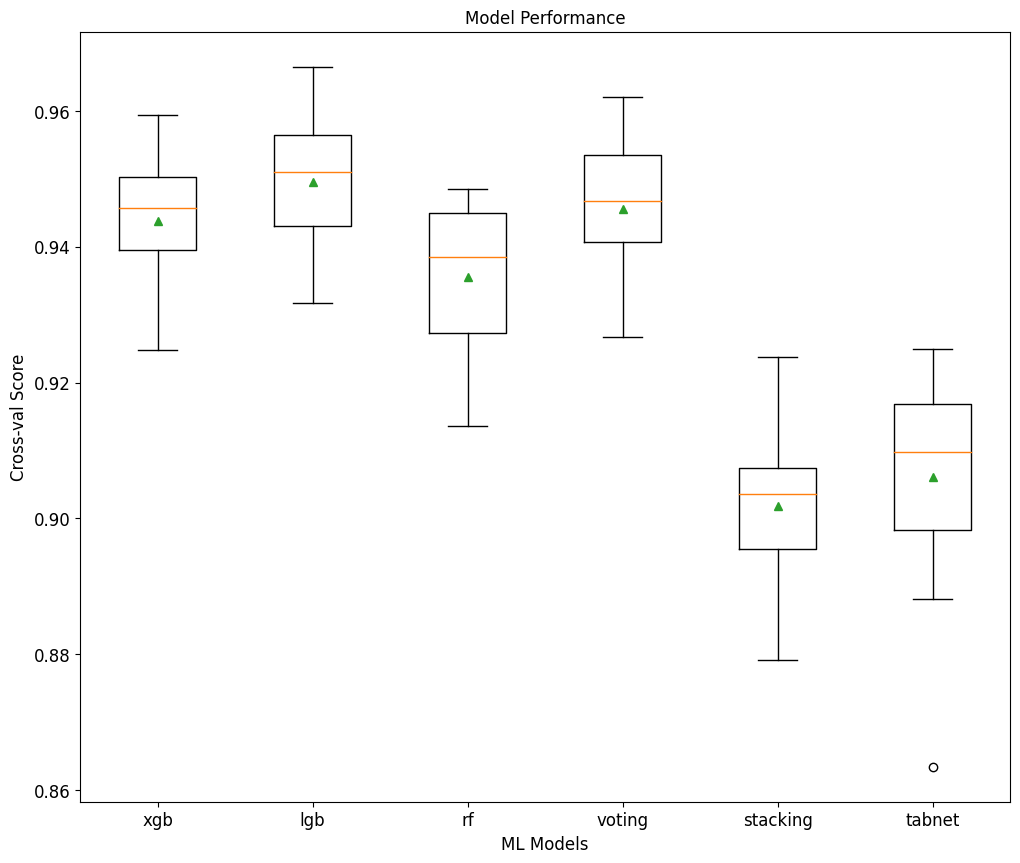

In [98]:
font_size = 12
plt.figure(figsize=(12,10))
plt.boxplot(results,labels = models.keys(), showmeans=True);
plt.title("Model Performance",  fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("Cross-val Score",  fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.show()


In [51]:
# looks like stacking is a bad idea! and TabeNet just not worth the time and efforts for this task, sigh!

In [50]:
test_results = []
for name,model in models.items():
    if name =='tabnet':
        model.fit(X_train.values.astype(np.float32),y_train.astype(np.float32))
        y_predict = model.predict_proba(X_test.values.astype(np.float32))[:,1]
        auc = roc_auc_score(y_test, y_predict)
    else:
        model.fit(X_train, y_train)
        y_predict = model.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_predict)
    
    test_results.append(auc)
    
pd.DataFrame(test_results,index = models.keys(),columns=['Testing AUC Score'])

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning:

No early stopping will be performed, last training weights will be used.



,Testing AUC Score
xgb,0.952494
lgb,0.958718
rf,0.944021
voting,0.955298
stacking,0.917043
tabnet,0.916844


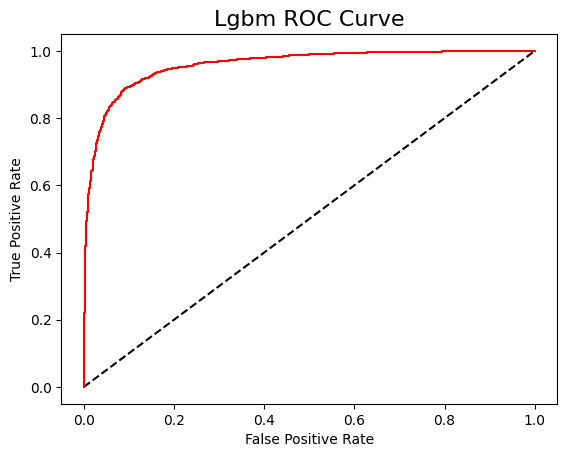

In [53]:
lgm_pred = lgb_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, lgm_pred)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Lgbm ROC Curve',fontsize=16)
plt.show();

### Conclusion

#### Lgb is the best performing model followed by xgb; an ensemble voting classifier is on the same level with xgb but stacking is worse off. Tabnet took the longest time to train but still lags considerably